## Topic modelling using comments on bitcoin forums

### Part I - Exploration

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords, brown
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tag import UnigramTagger

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wenlin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wenlin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wenlin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import emoji
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from pprint import pprint

In [3]:
import logging
import gensim 
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
# logging.basicConfig(level='warning')
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)
from wordcloud import WordCloud
import matplotlib.colors as mcolors
import pyLDAvis.gensim
import pyLDAvis

In [4]:
pd.set_option('max_rows', 1000)
pd.set_option('max_colwidth', 2000)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 2000]


In [5]:
posts = pd.read_csv("../Data-collected/splitbytopic.csv", encoding='utf-8')

C:\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253

In [7]:
posts.shape

(53382, 1324)

In [6]:
posts.isnull().sum()

Unnamed: 0          58
mark               512
comment            739
Unnamed: 3       52458
Unnamed: 4       52495
                 ...  
Unnamed: 1319    53381
Unnamed: 1320    53381
Unnamed: 1321    53381
Unnamed: 1322    53381
Unnamed: 1323    53381
Length: 1324, dtype: int64

In [6]:
posts = posts[['mark', 'comment']]
posts.fillna('NA', inplace=True) # fills in a few NA cells

In [8]:
posts.head()

mark  \
0                                                                                                                                                                                                                                                                                                                                                                                  2017/1/1/A Bitcoin-Eating Robot   
1                                                                                                                                                                                                                                                                                                                                                                         2017/1/1/Accepting payment unanonymously   
2                                                                                                                                                                                                                                                                                                                                                                 2017/1/1/Bitcoin: Halving on the Horizon {Video}   
3  2017/1/1/Bitcoinmarkets Party Hey guys, I think it's time we organized a Party. Let's have a blast and party like it's Dec 6th 2017. I will be in San Fransisco in March to visit some Bitcoiners, so maybe we organize a Party in Vegas? In April/May I can organize one in Europe. June in Asia? I'll be in Hong Kong for the whole month of June Anyone interested in getting fucked up with some Bitcorners   
4                                                                                                                                                                                                                                                                                                                                            2017/1/1/Downloading Blockchain on External Hard Disk is Recommended!   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [7]:
posts.dropna(axis=0, how='any', inplace=True)

In [10]:
posts.iloc[14,0]

'2017/1/1/[Daily Discussion] Sunday, January 01, 2017 Welcome to the r/BitcoinMarkets daily discussion thread! Thread topics include, but are not limited to: General discussion related to the days events Technical analysis Trading ideas & strategies Questions that do not warrant a separate post Thread Guidelines Be excellent to each other. Please do not create separate posts for the types of discussion mentioned above outside of the daily thread. If you do, your post may be removed and/or heavily downvoted. News that may have a big impact on the market may be posted as a separate thread. Other ways to interact Live chat on BitcoinMarkets IRC Set your flair to participate in the BitcoinMarkets Flair Game (view current standings) Weekly threads - Newbie Mondays and Fundamentals Fridays'

In [ ]:
'''
The daily discussion topics include:
1. General discussion on that day's events
2. Technical analysis
3. Trading ideas and strategies
4. Questions that do not warrant a separate thread

But the daily discussion may not include:
1. News that may have a big impact on the market

This means that topic modelling may not be very fruitful since most discussion topics will likely be captured in the same thread and there's not much point trying to separate posts from each other.

It may be better to see the change in topics over time instead of separating threads over the entire time period.
'''

In [8]:
# There is also a separate altcoin discussion thread that was started in April 2018, for the purpose of discussing other cryptocurrency than bitcoin.
altcoin_df = posts.loc[posts['comment'].str.contains('[Altcoin Discussion]', regex=False)]
altcoin_df.shape # 1326 out of 53,382 posts are altcoin discussions

(1326, 2)

In [10]:
altcoin_df.iloc[200,:]

mark                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [9]:
altcoin_df.head()

mark  \
18007  2017/11/25/MOVED: Ethereum Rising   
21742                         2018/1/5/1   
21779                         2018/1/6/1   
21827                         2018/1/7/1   
21859                         2018/1/8/1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               comment  
18007                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [8]:
# Repeated phrases to remove from post headings
dail_str = ['[Daily Discussion]',
'[Altcoin Discussion]',
'Altcoin Discussion',
'Altcoins Discussion',
'Welcome to the r/BitcoinMarkets daily discussion thread!',
'Thread topics include, but are not limited to',
'General discussion related to the days events',
"General discussion related to the day's events",
'Technical analysis Trading ideas & strategies',
'Technical analysis, Trading ideas & strategies',
'Technical analysis, trading ideas & strategies',
'Questions that do not warrant a separate post',
'Quick questions that do not warrant a separate post',
'Thread Guidelines',
'Thread guidelines',
'Be excellent to each other',
'Please do not create separate posts for the types of discussion mentioned above outside of the daily thread', 
'Do not make posts outside of the daily thread for the topics mentioned above',
'All regular rules for this subreddit apply, except for number 2',
'thread is exempt from the requirement that all discussion must relate to bitcoin trading',
'This is for high quality discussion of altcoins',
'Other ways to interact',
'Get an invite to live chat on our Slack group',
'Set your flair to trade pretend money in the Flair Game',
'Weekly threads: Newbie Mondays and Fundamentals Fridays',
'If you do, your post may be removed and/or heavily downvoted',
'News that may have a big impact on the market may be posted as a separate thread.',
'Live chat on BitcoinMarkets IRC',
'Set your flair to participate in the BitcoinMarkets Flair Game',
'(view current standings)',
'Weekly threads - Newbie Mondays and Fundamentals Fridays',
'Weekly threads: Newbie Mondays and Fundamentals Fridays']

In [12]:
dail_df = posts.loc[posts['comment'].str.contains('[Daily Discussion]', regex=False)]
dail_df.shape # 2,091 out of the 52,510 posts are 'Daily Discussion' or altcoin discussion posts

(2091, 2)

In [9]:
# Remove repeated strings from Daily Discussion posts
for stri in dail_str:
    posts['mark'] = posts['mark'].str.replace(stri, '', regex=False)
    posts['comment'] = posts['comment'].str.replace(stri, '', regex=False)

In [10]:
# Separate date in another column
def get_date(mystring):
  datestring = re.compile('\d{4}/\d{1,2}/\d{1,2}/')
  if datestring.match(mystring):
    return datestring.match(mystring).group()[:-1]
  else:
    return 'null'

posts['date'] = posts['mark'].apply(get_date)

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-10-af8ca00d1530>:3: DeprecationWarning: invalid escape sequence \d
  datestring = re.compile('\d{4}/\d{1,2}/\d{1,2}/')


In [11]:
# Remove date from post title
def remove_date(mystring):
  datestring = re.compile('\d{4}/\d{1,2}/\d{1,2}/')
  if datestring.match(mystring):
    return re.sub(datestring, '', mystring)
  else:
    return mystring

posts['mark'] = posts['mark'].apply(remove_date)

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-11-12881c8bac18>:3: DeprecationWarning: invalid escape sequence \d
  datestring = re.compile('\d{4}/\d{1,2}/\d{1,2}/')


In [25]:
posts.head()

mark  \
0                                                                                                                                                                                                                                                                                                                                                                                  A Bitcoin-Eating Robot   
1                                                                                                                                                                                                                                                                                                                                                                         Accepting payment unanonymously   
2                                                                                                                                                                                                                                                                                                                                                                 Bitcoin: Halving on the Horizon {Video}   
3  Bitcoinmarkets Party Hey guys, I think it's time we organized a Party. Let's have a blast and party like it's Dec 6th 2017. I will be in San Fransisco in March to visit some Bitcoiners, so maybe we organize a Party in Vegas? In April/May I can organize one in Europe. June in Asia? I'll be in Hong Kong for the whole month of June Anyone interested in getting fucked up with some Bitcorners   
4                                                                                                                                                                                                                                                                                                                                            Downloading Blockchain on External Hard Disk is Recommended!   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           comment  \


In [26]:
posts['mark_len'] = posts['mark'].astype(str).apply(len)
posts['comment_len'] = posts['comment'].astype(str).apply(len)

In [27]:
posts.describe()

mark_len   comment_len
count  53382.000000  53382.000000
mean      97.909483   3531.517834
std      331.546025   5656.977806
min        1.000000      1.000000
25%       32.000000    496.000000
50%       48.000000   1582.500000
75%       68.000000   4285.750000
max    17734.000000  32759.000000

### Exploring the dataset

- create bigrams and trigrams - if meaningful, add them to tokens for topic modelling
- POS tagging and special bitcoin words
- Look for emojis
- Look for '/s'
- topic modelling based on above results

In [28]:
posts.iloc[100:150,:]

last call.    
127                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     I just received 20 usd worth of bitcoins and it was Pending/Uncorfirmed just checked now  rel"ugc"    CoinspaymentReceived So Far:&nbsp;&nbsp;&nbsp;0.01862422 BTC (unconfirmed) rel"ugc"  Is that normal?  The fee for that transaction is 0.00001, or about 4.5 s/B, and the result is that the transaction may never be confirmed.Edit: blockchain.info now shows that the bitcoins have been double-spent. Is Coinpayments legitimate?  Yes coinpayments is good. im not using it for first time but i don't understand why it takes too much time for confirmation..  There is a doublespend and it will never confirm.You will not receive those coins, contact coinpayments support and advise them to reissue.  Alright. thank you.    
128  Who is Satoshi Nakamoto? Where are his Bitcoins?What is&nbsp; his Bitcoin address?Is he worth over $10 Billion USD today?    What if Satoshi was already a billionaire who didn't care how much he had&nbsp;   Possibly.But satoshi can't cash in on his BTC's as he would lose his anonymity.  There is a lot of information about Nakamoto Satoshi, however, we can not be sure that it is accurate, none of us knows about it, he can be a person or an organization working together and Developed, what we can be sure is that he is the one who created the bitcoin, he is a very talented person. I admire him. He knows very well what he has created, so I believe he is a billionaire, with his talent, money is too easy to get. I look forward to seeing him once.  Yes, this.Also, I expect the Bitcoin world to go crazy if Satoshi even just spends his BTC. Not mentioning cashing out or anything.Bitcoin price is due to it's scarcity. What if all of a sudden, he stops holding this 1M BTC and that gets to the market.Price should decrease.If Satoshi is still alive and holds his coins, that means in my opinion that he believes in the success of his experiment.As soon as he starts moving his stash bitcoiners will panic.  Do we have any proof of that 1M BTC? Do we know if he is holding any bitcoins at all? We naturally think so but what if he cashed out his bitcoins locally?All this anonymous Satoshi thing smells very shady btw. He can't stay anonymous with all those forum posts, emails and stuff. Nobody can.The secret service probably knows his identity or he is the secret service. There is no other explanation to that.  After 4 or so months here, I still haven't have the faintest idea of who he is or how to find him. &nbsp;If he does have that much btc though, I guess I would also prefer him to hold on to them, to avoid a sudden crash. Maybe when all the bitcoins have been mined, maybe he can release them into circulation bit by bit, so that there would still be some 

In [19]:
# Extract emojis
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI_ENGLISH)

my_emojis = []
for post in posts['comment']:
    my_emojis.extend(extract_emojis(post))

In [20]:
set(my_emojis) # There are not many emojis in the dataset

{'©', '®', '™'}

In [30]:
text = posts['comment'].astype(str)

In [31]:
print(text.head())

0    A Plantoid similarly takes energy in the form of a bitcoin and uses the funds to reproduce. It exists as a sculpture (a plant version of an android) and as a blockchain smart contract.-What can you say about this ?Read more here :     ">It is a hybrid entity that exists in both the virtual and physical realms and can interact with other entities on the blockchain.In its physical form, the Plantoid is a mechanical structure in a public space exhibiting beauty and seeking donations to its bitcoin wallet based on its attractiveness.</div>it is amazing! so the thing is like a robotic plant that can live by receiving bitcoin donations. so it looks like the wallet is its root that will look for food. but it is not actually "look for", but " receive". however, the art is so cool. I see the picture when the flower lights on. it is beautiful.  It's a hybrid eating bs story of epic proportions dude must have hit a line of talcum powder  its good news innovation, i am believe that if the tec

In [32]:
unigrams = [i.split() for i in text]

In [33]:
print("number of posts:", len(unigrams))
print("average number of words per post: ", np.mean([len(i) for i in unigrams]))

number of posts: 53382
average number of words per post:  624.8322280918662


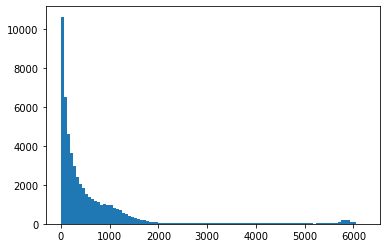

In [34]:
h = plt.hist([len(i) for i in unigrams], bins=100)

In [35]:
# flatten unigrams
flattened = [j for i in unigrams for j in i]

In [36]:
len(flattened)

33354794

In [37]:
bigrams = list(nltk.bigrams(flattened))
words_2 = nltk.FreqDist(bigrams)

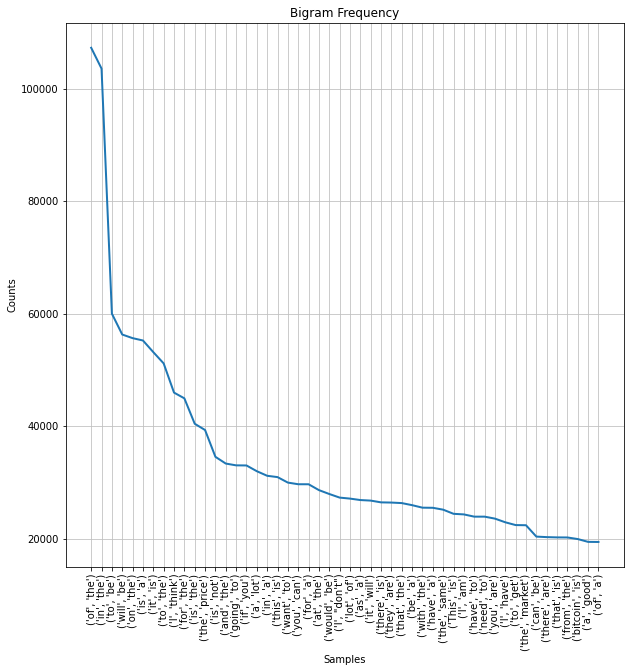

<AxesSubplot:title={'center':'Bigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [38]:
plt.figure(figsize=(10,10))
words_2.plot(50,title='Bigram Frequency')

In [39]:
list(words_2)[:20]
# may be more meaningful to do this after removing stopwords

[('of', 'the'),
 ('in', 'the'),
 ('to', 'be'),
 ('will', 'be'),
 ('on', 'the'),
 ('is', 'a'),
 ('it', 'is'),
 ('to', 'the'),
 ('I', 'think'),
 ('for', 'the'),
 ('is', 'the'),
 ('the', 'price'),
 ('is', 'not'),
 ('and', 'the'),
 ('going', 'to'),
 ('if', 'you'),
 ('a', 'lot'),
 ('in', 'a'),
 ('this', 'is'),
 ('want', 'to')]

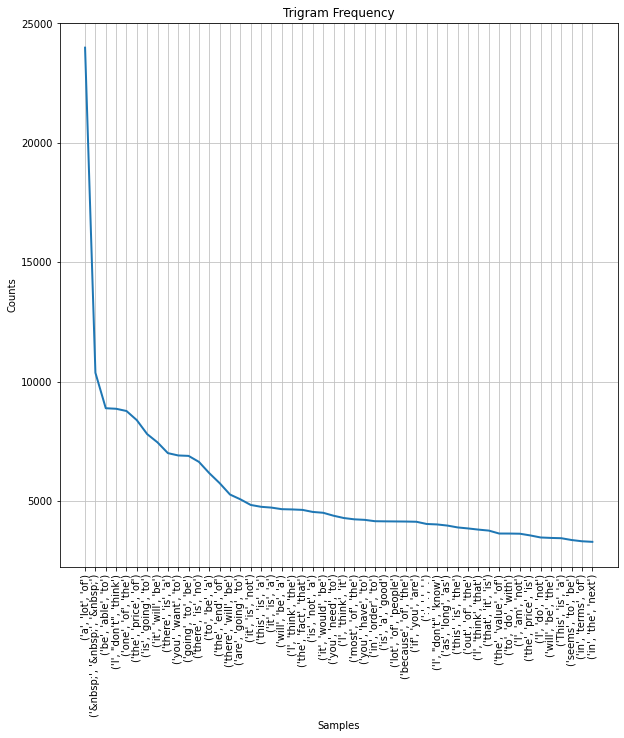

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [40]:
trigrams = list(nltk.trigrams(flattened))
words_3 = nltk.FreqDist(trigrams)
plt.figure(figsize=(10,10))
words_3.plot(50,title='Trigram Frequency')

In [12]:
mystopwords=stopwords.words("english") + ["n't", "'s", "nbsp", "&nbsp;", "/div", "'ll", "'m", "'re", "/span", "also", "go", "say", "get", "see", "thread", "rule"]
flattened_nostop = [t for t in flattened if t not in mystopwords]


NameError: name 'flattened' is not defined

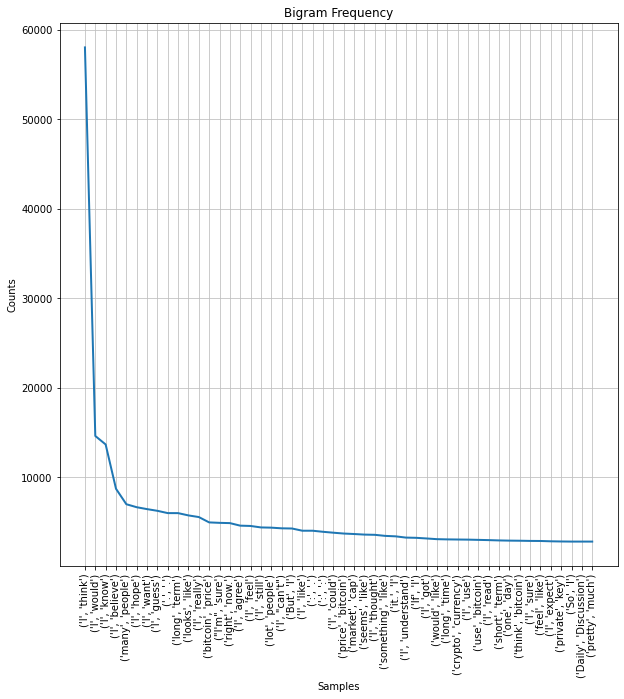

<AxesSubplot:title={'center':'Bigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [42]:
bigrams2 = list(nltk.bigrams(flattened_nostop))
words_3 = nltk.FreqDist(bigrams2)
plt.figure(figsize=(10,10))
words_3.plot(50,title='Bigram Frequency')

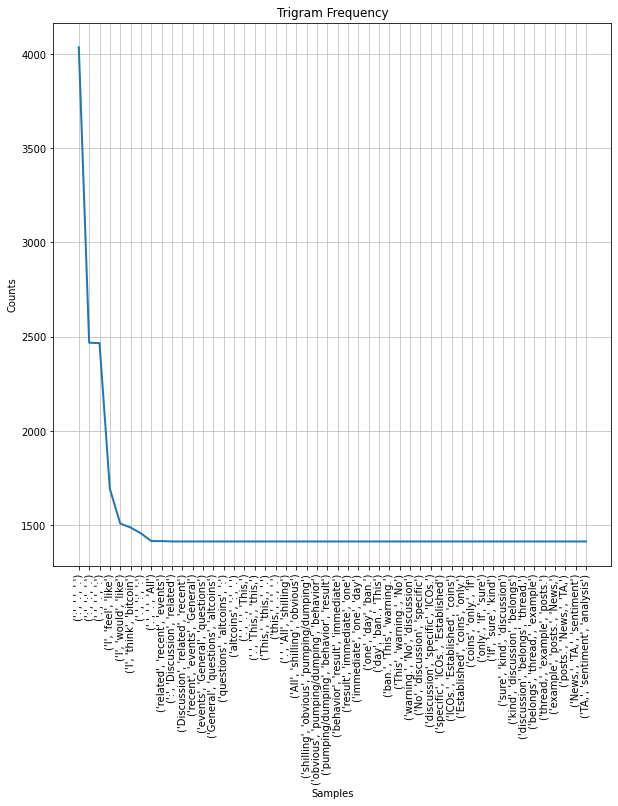

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [43]:
trigrams2 = list(nltk.trigrams(flattened_nostop))
words_3 = nltk.FreqDist(trigrams2)
plt.figure(figsize=(10,10))
words_3.plot(50,title='Trigram Frequency')
# all relating to the altcoin discussion posts

In [13]:
# Join mark and comment columns
posts['post'] = posts['mark'] + " " + posts['comment']

In [45]:
# Words specific to bitcoin that are likely not in the dictionary
# or used in crypto context in different ways than in normal language

model = {'bitcoin': 'NN',
'btc': 'NN',
'altcoin': 'NN',
'blockchain': 'NN',
'ethereum': 'NN',
'satoshi': 'NN',
'fiat': 'NN',
'crypto': 'NN',
'cryptocurrency': 'NN',
'okcoin': 'NP',
'bitfinex': 'NP',
'bfx': 'NP',
'huobi': 'NP',
'okex': 'NP',
'gdax': 'NP',
'coinbase': 'NP',
'kraken': 'NP',
'gemini': 'NP',
'binance': 'NP',
'okc': 'NP',
'bitcoin-e': 'NN',
'btce': 'NN',
'mtgox': 'NP',
'grayscale': 'NP',
'gbtc': 'NP',
'microstrategy': 'NP',
'etf':'NN',
'hashrate':'NN',
'nakamoto': 'NP',
'fomo': 'NN',
'ath': 'NN',
'long': 'NN',
'short': 'NN',
'ico': 'NN',
'fud': 'NN',
'moon': 'VB',
'pump': 'VB',
'dump': 'VB',
'bottom': 'VB',
'hedge': 'VB',
'usd': 'NN',
'eur': 'NN',
'bullish': 'JJ',
'bearish': 'JJ',
'bull': 'JJ'
}

In [46]:
# Add special bitcoin words to tagger (has priority over the pre-trained tagger)
# Where unknown word, assign as noun

default_tagger = nltk.tag.UnigramTagger(brown.tagged_sents(), backoff=nltk.DefaultTagger('NN'))
tagger = nltk.tag.UnigramTagger(model=model, backoff=default_tagger)
tagger.tag(word_tokenize("i would like to hodl some bitcoin. Feeling bullish about this"))


[('i', 'NN'),
 ('would', 'MD'),
 ('like', 'CS'),
 ('to', 'TO'),
 ('hodl', 'NN'),
 ('some', 'DTI'),
 ('bitcoin', 'NN'),
 ('.', '.'),
 ('Feeling', 'VBG'),
 ('bullish', 'JJ'),
 ('about', 'IN'),
 ('this', 'DT')]

In [47]:
tagger.tag(word_tokenize("A Plantoid similarly takes energy in the form of a bitcoin and uses the funds to reproduce. It exists as a sculpture (a plant version of an android) and as a blockchain smart contract.-What can you say about this ?"))


[('A', 'AT'),
 ('Plantoid', 'NN'),
 ('similarly', 'RB'),
 ('takes', 'VBZ'),
 ('energy', 'NN'),
 ('in', 'IN'),
 ('the', 'AT'),
 ('form', 'NN'),
 ('of', 'IN'),
 ('a', 'AT'),
 ('bitcoin', 'NN'),
 ('and', 'CC'),
 ('uses', 'VBZ'),
 ('the', 'AT'),
 ('funds', 'NNS'),
 ('to', 'TO'),
 ('reproduce', 'VB'),
 ('.', '.'),
 ('It', 'PPS'),
 ('exists', 'VBZ'),
 ('as', 'CS'),
 ('a', 'AT'),
 ('sculpture', 'NN'),
 ('(', '('),
 ('a', 'AT'),
 ('plant', 'NN'),
 ('version', 'NN'),
 ('of', 'IN'),
 ('an', 'AT'),
 ('android', 'NN'),
 (')', ')'),
 ('and', 'CC'),
 ('as', 'CS'),
 ('a', 'AT'),
 ('blockchain', 'NN'),
 ('smart', 'JJ'),
 ('contract.-What', 'NN'),
 ('can', 'MD'),
 ('you', 'PPSS'),
 ('say', 'VB'),
 ('about', 'IN'),
 ('this', 'DT'),
 ('?', '.')]

In [55]:
# POS tagging of all posts - store it in a list of lists
pos_posts = []

for post in posts['post']:
    tokens = word_tokenize(post)
    # tokens = [ t.lower() for t in tokens if t.lower() not in mystopwords]
    # tokens = [t for t in tokens if t not in punct]
    sent_pos = tagger.tag(tokens)
    pos_posts.append(sent_pos)
    

In [56]:
len(pos_posts)

53382

### Part II: Topic Modelling

1. Split by year
2. Topic modelling to find best number of topics per year (elbow graph)
3. Get topics for each year
4. Visualise the topics for each year
5. get typical document representing each topic for each year

In [14]:
posts['year'] = posts['date'].str[:4]

<AxesSubplot:xlabel='year', ylabel='Count'>

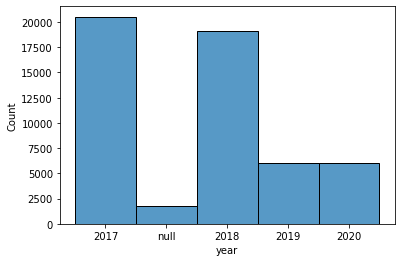

In [42]:
sns.histplot(posts['year'])

<AxesSubplot:xlabel='comment_len', ylabel='Count'>

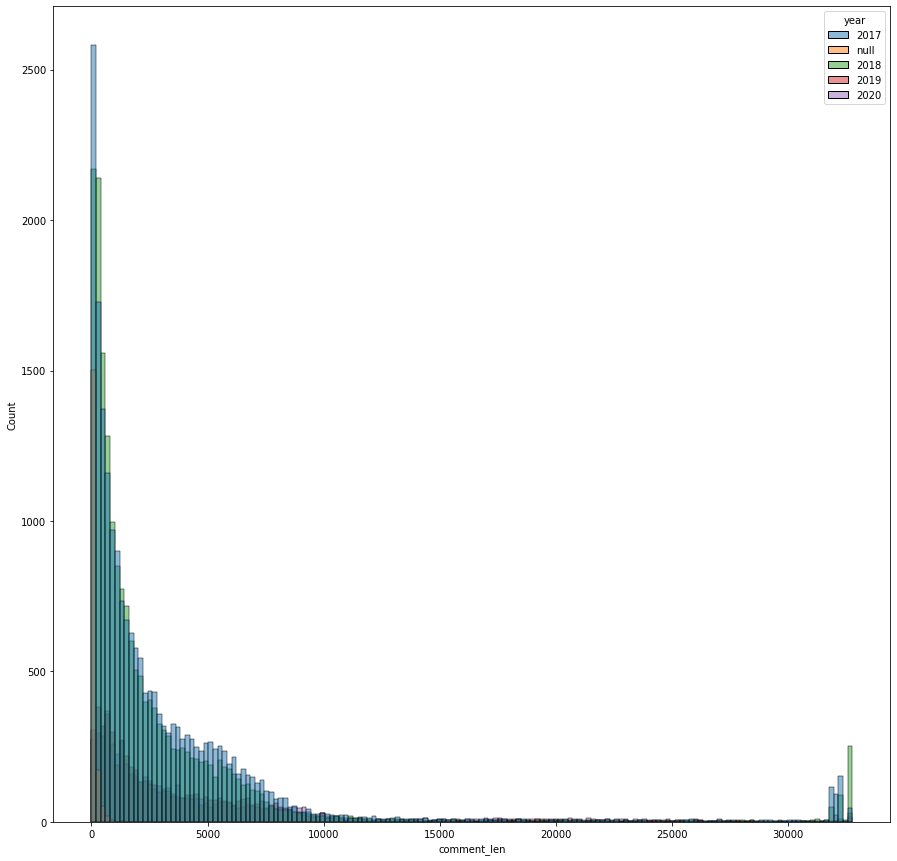

In [43]:
plt.figure(figsize=(15,15))
sns.histplot(posts, x='comment_len', hue='year')

In [29]:
## Functions and definitions

# Words specific to bitcoin that are likely not in the dictionary
# or used in crypto context in different ways than in normal language

model = {'bitcoin': 'NN',
'btc': 'NN',
'altcoin': 'NN',
'blockchain': 'NN',
'ethereum': 'NN',
'satoshi': 'NN',
'fiat': 'NN',
'crypto': 'NN',
'cryptocurrency': 'NN',
'okcoin': 'NP',
'bitfinex': 'NP',
'bfx': 'NP',
'huobi': 'NP',
'okex': 'NP',
'gdax': 'NP',
'coinbase': 'NP',
'kraken': 'NP',
'gemini': 'NP',
'binance': 'NP',
'okc': 'NP',
'bitcoin-e': 'NN',
'btce': 'NN',
'mtgox': 'NP',
'grayscale': 'NP',
'gbtc': 'NP',
'microstrategy': 'NP',
'etf':'NN',
'hashrate':'NN',
'nakamoto': 'NP',
'fomo': 'NN',
'ath': 'NN',
'long': 'NN',
'short': 'NN',
'ico': 'NN',
'fud': 'NN',
'moon': 'VB',
'pump': 'VB',
'dump': 'VB',
'bottom': 'VB',
'hedge': 'VB',
'usd': 'NN',
'eur': 'NN',
'bullish': 'JJ',
'bearish': 'JJ',
'bull': 'JJ'
}

# Part of speech tagger
default_tagger = nltk.tag.UnigramTagger(brown.tagged_sents(), backoff=nltk.DefaultTagger('NN'))
tagger = nltk.tag.UnigramTagger(model=model, backoff=default_tagger)

# Stopwords
wnl = nltk.WordNetLemmatizer()
mystopwords=stopwords.words("english") + ["bitcoin", "n't", "'s", "nbsp", "&nbsp;", "/div", "'ll", "'m", "'re", "/span", "also", "go", "say", "get", "see", "thread", "rule"]
punct = '.,!?()""\'/<>\\^*#„\{\}....'

<>:60: DeprecationWarning: invalid escape sequence \{
<>:60: DeprecationWarning: invalid escape sequence \{
<>:60: DeprecationWarning: invalid escape sequence \{
<ipython-input-29-5a5abb2371d0>:60: DeprecationWarning: invalid escape sequence \{
  punct = '.,!?()""\'/<>\\^*#„\{\}....'


In [30]:
# Functions for pre-processing

def pre_process_docs(df):
    posts = df['mark'] + " " + df['comment']
    # POS tagging of all posts in df - store in a list of lists
    pos_posts = []
    for post in posts:
        tokens = word_tokenize(post)
        sent_pos = tagger.tag(tokens)
        pos_posts.append(sent_pos)
    
    # Extract all nouns, adjectives, verbs, adverbs (keep as separate posts)
    processed_docs = []
    for post in pos_posts:
        words = []
        for w, pos in post:
            if w.lower() not in mystopwords and w not in punct and pos[0] in ('N', 'V', 'J', 'R'): # noun, verb, adjective, adverb
                # lemmatize then add to list
                pos_label = 'a' if pos[0].lower() == 'j' else pos[0].lower()
                words.append(wnl.lemmatize(w.lower(), pos=pos_label))
        processed_docs.append(words)
    return processed_docs

# Just using nouns

def pre_process_docs_nouns(df):
    posts = df['mark'] + " " + df['comment']
    # POS tagging of all posts in df - store in a list of lists
    pos_posts = []
    for post in posts:
        tokens = word_tokenize(post)
        sent_pos = tagger.tag(tokens)
        pos_posts.append(sent_pos)
    
    processed_docs = []
    for post in pos_posts:
        words = []
        for w, pos in post:
            if w.lower() not in mystopwords and w not in punct and pos[0] in ('N'): # noun, verb, adjective, adverb
                # lemmatize then add to list
                words.append(wnl.lemmatize(w.lower(), pos=pos[0].lower()))
        processed_docs.append(words)
    return processed_docs

In [52]:
processed_docs = pre_process_docs(posts)
print("processed")

processed


In [53]:
processed_docs_nouns = pre_process_docs_nouns(posts)
print("processed nouns")

processed nouns


In [54]:
print(len(processed_docs))
print(processed_docs[0])

53382
['bitcoin-eating', 'robot', 'plantoid', 'similarly', 'take', 'energy', 'form', 'use', 'fund', 'reproduce', 'exist', 'sculpture', 'plant', 'version', 'android', 'blockchain', 'smart', 'contract.-what', 'read', 'hybrid', 'entity', 'exist', 'virtual', 'physical', 'realm', 'interact', 'entity', 'blockchain.in', 'physical', 'form', 'plantoid', 'mechanical', 'structure', 'public', 'space', 'exhibit', 'beauty', 'seek', 'donation', 'wallet', 'base', 'attractiveness.', 'amazing', 'thing', 'robotic', 'plant', 'live', 'receive', 'donation', 'look', 'wallet', 'root', 'look', 'food', 'actually', 'look', 'receive', 'however', 'art', 'cool', 'picture', 'flower', 'light', 'beautiful', 'hybrid', 'eat', 'b', 'story', 'epic', 'proportion', 'dude', 'hit', 'line', 'talcum', 'powder', 'good', 'news', 'innovation', 'believe', 'technology', 'growth', 'fast', 'technology', 'almost', 'human', 'work', 'maybe', 'future', 'use', 'robot', 'mine', 'activity', 'send', 'receive', 'way', 'use', 'wallet', 'future'

In [55]:
print(len(processed_docs_nouns))
print(processed_docs_nouns[0])

53382
['bitcoin-eating', 'robot', 'plantoid', 'energy', 'form', 'fund', 'sculpture', 'plant', 'version', 'android', 'blockchain', 'contract.-what', 'hybrid', 'entity', 'realm', 'entity', 'blockchain.in', 'form', 'plantoid', 'structure', 'space', 'beauty', 'donation', 'wallet', 'attractiveness.', 'thing', 'robotic', 'plant', 'donation', 'wallet', 'root', 'food', 'art', 'picture', 'flower', 'light', 'hybrid', 'b', 'story', 'epic', 'proportion', 'dude', 'line', 'talcum', 'powder', 'news', 'innovation', 'technology', 'growth', 'technology', 'work', 'future', 'use', 'robot', 'activity', 'way', 'wallet', 'future', 'imagination', 'concept', 'water', 'plant', 'amount', 'btc', 'search', 'design', 'flower', 'btc', 'benefit', 'concept', 'artist', 'job', 'robotic', 'flower', 'flower', 'piece', 'hardware', 'kind', 'way', 'article', 'ton', 'concept', 'picture', 'cool.the', 'contract', 'enforcement', 'system', 'premise', 'technology', 'work', 'purpose', 'feed', 'altcoins', 'fiat', 'lol', 'world', 'is

In [56]:
# Save processed_docs as pickle file

with open('processed_docs.pkl', 'wb') as filehandler:
    pickle.dump(processed_docs, filehandler)
with open('processed_docs_nouns.pkl', 'wb') as filehandler:
    pickle.dump(processed_docs_nouns, filehandler)

In [16]:
#######################################################################
# Open processed_docs from pickle file
with open('processed_docs.pkl', 'rb') as filehandler:
    processed_docs = pickle.load(filehandler)
with open('processed_docs_nouns.pkl', 'rb') as filehandler:
    processed_docs_nouns = pickle.load(filehandler)

In [31]:
# function to get coherence scores for range of numbers of topics, and plot coherence score graph 

def topics_and_coherence(processed_docs, start_num, num_range):
    # Create dictionary from corpus
    dictionary = corpora.Dictionary(processed_docs)
    # Filter off  words with document frequency less than 3, or appearing in more than 90% of documents
    dictionary.filter_extremes(no_below=3, no_above=0.90)
    # Making Doc-term matrix using all words in the corpus
    dtm = [dictionary.doc2bow(d) for d in processed_docs] 
    
    # df to store topics and coherence scores
    tc_df = pd.DataFrame(columns=['num_topics', 'coherence_score', 'perplexity_lda', 'topics', 'lda_model'])

    for i in range(start_num, num_range):
        print("\nnumber of topics:", i)
        # Topic modelling using LDA
        lda_model = gensim.models.ldamodel.LdaModel(dtm, num_topics = i, id2word = dictionary)
        topics = lda_model.show_topics(num_words=15) 
        # Compute Coherence Score using c_v
        coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        print('Coherence Score: ', coherence_lda)
        # Compute perplexity
        perplexity_lda = lda_model.log_perplexity(dtm)
        print('Perplexity Score:', perplexity_lda)
        # Store topics and coherence score in tc_df
        tc_df.loc[len(tc_df)] = [i, coherence_lda, perplexity_lda, topics, lda_model]
    return tc_df


In [58]:
result_df2 = topics_and_coherence(processed_docs, 2, 15)


number of topics: 2
Coherence Score:  0.32332970409836315
Perplexity Score: -7.639950929875563

number of topics: 3
Coherence Score:  0.3173859959333784
Perplexity Score: -7.6304703754811305

number of topics: 4
Coherence Score:  0.3582529006385475
Perplexity Score: -7.603221779814002

number of topics: 5
Coherence Score:  0.3568107698257297
Perplexity Score: -7.605522797024653

number of topics: 6
Coherence Score:  0.3778709858299365
Perplexity Score: -7.613695721575594

number of topics: 7
Coherence Score:  0.3615267613553727
Perplexity Score: -7.651388358475423

number of topics: 8
Coherence Score:  0.38335697963166887
Perplexity Score: -7.690913321015429

number of topics: 9
Coherence Score:  0.42935141609868616
Perplexity Score: -7.760870734140002

number of topics: 10
Coherence Score:  0.37754952378939033
Perplexity Score: -7.810959042923757

number of topics: 11
Coherence Score:  0.395072555238653
Perplexity Score: -7.860511212271439

number of topics: 12
Coherence Score:  0.38

In [59]:
result_df2_nouns = topics_and_coherence(processed_docs_nouns, 2, 15)


number of topics: 2
Coherence Score:  0.3575161159892012
Perplexity Score: -7.4981055443586335

number of topics: 3
Coherence Score:  0.35778892183324834
Perplexity Score: -7.44638006071607

number of topics: 4
Coherence Score:  0.42593636934186263
Perplexity Score: -7.417599902452777

number of topics: 5
Coherence Score:  0.42866770526628556
Perplexity Score: -7.409074734708771

number of topics: 6
Coherence Score:  0.3956838120734632
Perplexity Score: -7.428082597655687

number of topics: 7
Coherence Score:  0.4207970242932326
Perplexity Score: -7.488339689877491

number of topics: 8
Coherence Score:  0.40894945105425
Perplexity Score: -7.553166397955559

number of topics: 9
Coherence Score:  0.42634456119558817
Perplexity Score: -7.654274981053742

number of topics: 10
Coherence Score:  0.4517618473044239
Perplexity Score: -7.744383398655147

number of topics: 11
Coherence Score:  0.43445931665071136
Perplexity Score: -7.871392907678026

number of topics: 12
Coherence Score:  0.447

In [60]:
result_df2

num_topics  coherence_score  perplexity_lda  \
0           2         0.323330       -7.639951   
1           3         0.317386       -7.630470   
2           4         0.358253       -7.603222   
3           5         0.356811       -7.605523   
4           6         0.377871       -7.613696   
5           7         0.361527       -7.651388   
6           8         0.383357       -7.690913   
7           9         0.429351       -7.760871   
8          10         0.377550       -7.810959   
9          11         0.395073       -7.860511   
10         12         0.389328       -7.906712   
11         13         0.391125       -7.944744   
12         14         0.395741       -7.982535   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             topics  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [61]:
result_df2_nouns

num_topics  coherence_score  perplexity_lda  \
0           2         0.357516       -7.498106   
1           3         0.357789       -7.446380   
2           4         0.425936       -7.417600   
3           5         0.428668       -7.409075   
4           6         0.395684       -7.428083   
5           7         0.420797       -7.488340   
6           8         0.408949       -7.553166   
7           9         0.426345       -7.654275   
8          10         0.451762       -7.744383   
9          11         0.434459       -7.871393   
10         12         0.447262       -7.950681   
11         13         0.469133       -7.998381   
12         14         0.449128       -8.083565   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             topics  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [62]:
with open('topics_results_all.pkl', 'wb') as filehandler:
    pickle.dump(result_df2, filehandler)
with open('topics_results_all_nouns.pkl', 'wb') as filehandler2:
    pickle.dump(result_df2_nouns, filehandler2)

In [17]:
with open('topics_results_all.pkl', 'rb') as filehandler:
    result_df2 = pickle.load(filehandler)
with open('topics_results_all_nouns.pkl', 'rb') as filehandler2:
    result_df2_nouns = pickle.load(filehandler2)

<AxesSubplot:xlabel='num_topics', ylabel='coherence_score'>

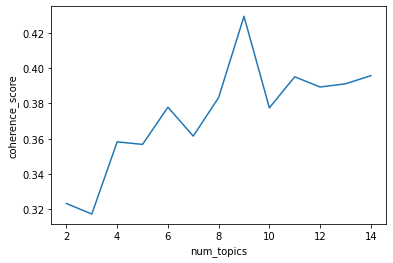

In [63]:
sns.lineplot(data=result_df2, x="num_topics", y="coherence_score")

<AxesSubplot:xlabel='num_topics', ylabel='coherence_score'>

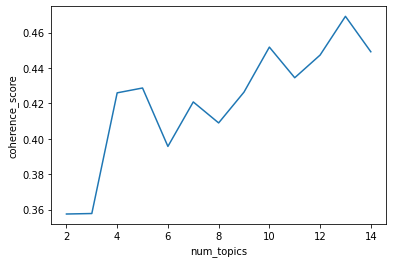

In [64]:
sns.lineplot(data=result_df2_nouns, x="num_topics", y="coherence_score")

In [65]:
# pyLDAvis for all data
chosen_model = result_df2.iloc[4,4]
dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=3, no_above=0.90)
dtm = [dictionary.doc2bow(d) for d in processed_docs] 

In [66]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(chosen_model, dtm, dictionary)
LDAvis_prepared

day   16319.473929   57225.067897   Topic1  -5.4247   
802                 long   15889.606027   57566.409878   Topic1  -5.4514   
119                 take   15885.930793   58316.798599   Topic1  -5.4516   
685                  get   15563.148287   54343.511523   Topic1  -5.4722   
121                thing   15622.329736   57515.671932   Topic1  -5.4684   
256                    %   15602.356536   61758.965493   Topic1  -5.4697   
19441             valign     807.660359     808.523163   Topic2  -8.4182   
2979                 /td     802.077470     802.969507   Topic2  -8.4252   
1489            cashless     575.401025     576.276609   Topic2  -8.7573   
20919         bangladesh     400.288397     401.090701   Topic2  -9.1202   
8595                 rbi     385.049027     385.865393   Topic2  -9.1590   
2852                film     498.627497     499.731322   Topic2  -8.9005   
48571               cbdc     496.107598     497.262659   Topic2  -8.9056   
15724            inherit    1871.071198    1876.341132   Topic2  -7.5781   
22257      environmental     268.901555     269.775786   Topic2  -9.5180   
29363         e-commerce     234.014789     234.812630   Topic2  -9.6570   
24120          footprint     212.419183     213.242114   Topic2  -9.7538   
32670              petro     206.498345     207.302150   Topic2  -9.7821   
4783            legalize    1060.028422    1064.268368   Topic2  -8.1463   
22696               yang     199.684382     200.499498   Topic2  -9.8156   
14093               font     935.938221     939.952002   Topic2  -8.2708   
17055           epidemic     210.612136     211.519761   Topic2  -9.7624   
23635         republican     191.579611     192.416805   Topic2  -9.8571   
22044          trademark     180.248198     181.085588   Topic2  -9.9181   
2980                 /tr     171.894889     172.716268   Topic2  -9.9655   
31391           democrat     165.235223     166.126698   Topic2 -10.0050   
9523             poverty     421.210008     423.552019   Topic2  -9.0693   
28099          coingecko     174.909654     175.894347   Topic2  -9.9481   
19801            jewelry     140.395822     141.195287   Topic2 -10.1679   
15833         curriculum     141.026688     141.829843   Topic2 -10.1634   
10762          ecommerce     145.784054     146.666480   Topic2 -10.1303   
4658            banknote     299.218107     301.094267   Topic2  -9.4112   
13103          hollywood     130.249811     131.072360   Topic2 -10.2429   
19752    cryptocurrency.     130.793648     131.664550   Topic2 -10.2388   
6635             village     131.788239     132.669504   Topic2 -10.2312   
4562               ified     145.205405     146.200457   Topic2 -10.1342   
694           government   25809.036493   26885.365458   Topic2  -4.9539   
13469            african     557.696423     563.183451   Topic2  -8.7886   
14148            vaccine     517.604105     525.927193   Topic2  -8.8632   
39126                g20     220.181920     221.906481   Topic2  -9.7179   
10222       crowdfunding     299.398898     302.912918   Topic2  -9.4106   
4791             seminar     317.060758     321.109568   Topic2  -9.3533   
8314          philippine     797.814438     815.801437   Topic2  -8.4305   
515              country   28922.370659   30972.102181   Topic2  -4.8400   
2293             society    1814.690533    1893.381651   Topic2  -7.6087   
2367           venezuela    1087.925145    1125.519466   Topic2  -8.1204   
2238          corruption     566.304298     578.736187   Topic2  -8.7733   
7746              africa    1248.219363    1300.654297   Topic2  -7.9829   
525             currency   29228.681673   32548.276613   Topic2  -4.8295   
120           technology   14892.426174   16348.416845   Topic2  -5.5038   
3859              russia    1306.633683    1369.550971   Topic2  -7.9372   
623             facebook    2810.000338    3034.614767   Topic2  -7.1714   
2810          university    1026.794034    1077.986899   Topic2  -8.1

In [33]:
pyLDAvis.save_html(LDAvis_prepared, 'ldamodelviz.html')

In [22]:
# pyLDAvis for all data, nouns only
chosen_model_n = result_df2_nouns.iloc[4,4]
dictionary_n = corpora.Dictionary(processed_docs_nouns)
dictionary_n.filter_extremes(no_below=3, no_above=0.90)
dtm_n = [dictionary_n.doc2bow(d) for d in processed_docs_nouns]

In [23]:
pyLDAvis.enable_notebook()
LDAvis_prepared_n = pyLDAvis.gensim.prepare(chosen_model_n, dtm_n, dictionary_n)
LDAvis_prepared_n

¢s   31146.000000   31146.000000  Default   8.0000   
346            currency   34133.000000   34133.000000  Default   7.0000   
838      cryptocurrency   31221.000000   31221.000000  Default   6.0000   
10           blockchain   30038.000000   30038.000000  Default   5.0000   
327            coinbase   15934.000000   15934.000000  Default   4.0000   
1              altcoins   14998.000000   14998.000000  Default   3.0000   
43               people  137225.000000  137225.000000  Default   2.0000   
42                 news   28402.000000   28402.000000  Default   1.0000   
10124              wick    3235.733768    3236.970791   Topic1  -6.7790   
635                 rsi    4601.994028    4604.001163   Topic1  -6.4268   
3132             retest    1967.830009    1968.948808   Topic1  -7.2764   
728            triangle    4946.902767    4949.718722   Topic1  -6.3545   
47362               bgd    1467.685791    1468.544309   Topic1  -7.5696   
4851              wedge    2600.326695    2601.857044   Topic1  -6.9977   
2978                 4h    2058.482389    2059.795596   Topic1  -7.2313   
7844                 9k    3347.551242    3349.768581   Topic1  -6.7451   
47433              bart    1261.329183    1262.198292   Topic1  -7.7211   
23033               sma    1171.022406    1171.882228   Topic1  -7.7954   
2051                4hr    1263.056785    1264.006212   Topic1  -7.7198   
277            breakout    3600.238394    3603.450229   Topic1  -6.6723   
39256                oi     964.014665     964.942561   Topic1  -7.9900   
8308                ema     967.362562     968.328943   Topic1  -7.9865   
4230          trendline    1295.201614    1296.500162   Topic1  -7.6946   
4112                dca    2386.730137    2389.136296   Topic1  -7.0834   
2346             hopium    1061.362260    1062.457849   Topic1  -7.8937   
1385            retrace    1694.695631    1696.530662   Topic1  -7.4258   
7771              10.5k     809.836448     810.720799   Topic1  -8.1642   
4196                pnf     987.304963     988.386901   Topic1  -7.9661   
2154               macd    1732.323496    1734.302960   Topic1  -7.4038   
12216           pennant     869.762596     870.763556   Topic1  -8.0928   
10343        timeframes     900.514662     901.557755   Topic1  -8.0581   
203                  6k    3880.880162    3885.494838   Topic1  -6.5972   
21199              9500     673.766137     674.632109   Topic1  -8.3482   
3119           pullback    2274.467037    2277.400390   Topic1  -7.1316   
6294                14k    2230.575092    2233.522541   Topic1  -7.1510   
4137            fractal     713.506537     714.472970   Topic1  -8.2909   
32325               spx     609.212929     610.085885   Topic1  -8.4489   
314                chop     888.058289     889.332608   Topic1  -8.0720   
296              candle    6232.027902    6248.583242   Topic1  -6.1236   
288                bull    5103.519168    5134.440527   Topic1  -6.3234   
175                 12k    3116.505446    3122.875529   Topic1  -6.8166   
7264                 8k    2822.964578    2827.691201   Topic1  -6.9155   
309               chart   18940.609850   19354.291453   Topic1  -5.0120   
208                  7k    2114.144882    2119.438389   Topic1  -7.2047   
629          resistance   10432.866467   10633.970840   Topic1  -5.6083   
3964                 3k    2299.729526    2310.976107   Topic1  -7.1205   
4084               bear    1595.306791    1598.704418   Topic1  -7.4862   
1222      consolidation    2253.260378    2266.506984   Topic1  -7.1409   
3581         divergence    1460.974100    1463.348150   Topic1  -7.5742   
2216           reversal    2413.686860    2430.148573   Topic1  -7.0721   
240                 ath   11657.419455   11963.122629   Topic1  -5.4974   
1244          downtrend    2146.374580    2163.013393   Topic1  -7.1895   
3776                11k    1873.790650    1886.911262   Topic1  -7.3253   
166                 10k    9895.187285   10330

In [ ]:
pyLDAvis.save_html(LDAvis_prepared_n, 'ldamodelviz_nouns.html')

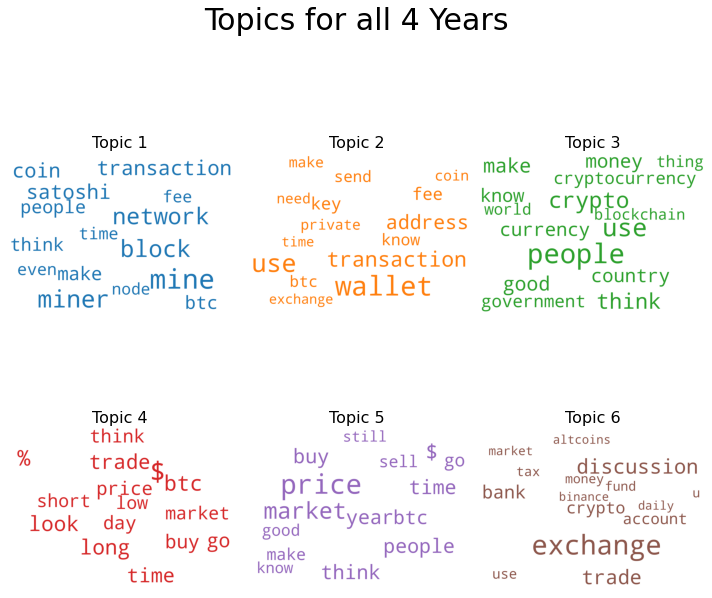

In [24]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=None,
                background_color='white',
                width=2500,
                height=1800,
                max_words=15,
                colormap='tab10',
                color_func=lambda *args, **kwargs: cols[i],
                prefer_horizontal=1.0)

topics = result_df2.iloc[4,4].show_topics(num_words=15,formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
fig.suptitle(f'Topics for all 4 Years', fontsize=30)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(f'Topic {i+1}', fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

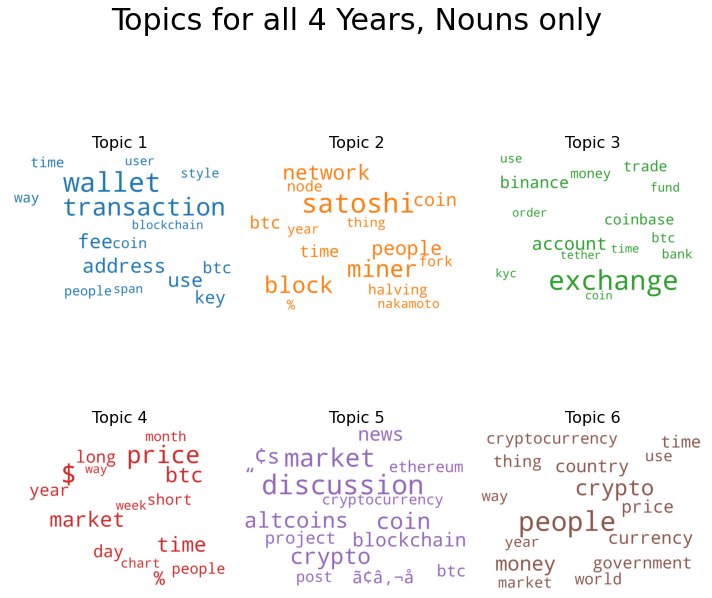

In [25]:
topics_n = result_df2_nouns.iloc[4,4].show_topics(num_words=15,formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
fig.suptitle(f'Topics for all 4 Years, Nouns only', fontsize=30)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words_n = dict(topics_n[i][1])
    cloud.generate_from_frequencies(topic_words_n, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(f'Topic {i+1}', fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [66]:
topicdict = {0: 'topic 1', 1: 'topic 2', 2: 'topic 3', 3:'topic 4', 4:'topic 5', 5:'topic 6'}

# Get the topic distribution of documents
doc_topics = chosen_model.get_document_topics(dtm)
#show the topic distributions for the first 5 docs, 
for i in range(6):
    print(doc_topics[i])

# Select the best topic (with highest score) for each document
from operator import itemgetter
top_topic = [ max(t, key=itemgetter(1))[0] for t in doc_topics ]
topics_perDoc = [ topicdict[t] for t in top_topic ]

[(0, 0.058236375), (2, 0.17743534), (4, 0.046861812), (5, 0.7155839)]
[(2, 0.9568256), (5, 0.040333744)]
[(0, 0.021222973), (1, 0.020983078), (2, 0.021048687), (3, 0.020963153), (4, 0.5122973), (5, 0.40348485)]
[(0, 0.06462069), (1, 0.021719053), (3, 0.19072223), (4, 0.6127974), (5, 0.10182742)]
[(1, 0.24037041), (2, 0.7174257), (5, 0.03586028)]
[(2, 0.14533111), (3, 0.8254108)]


In [68]:
# Number of documents in each topic
labels, counts = np.unique(topics_perDoc, return_counts=True)
print (labels)
print (counts)

['topic 1' 'topic 2' 'topic 3' 'topic 4' 'topic 5' 'topic 6']
[ 9415  5261  8450  4881  6174 19201]


In [ ]:
###################################################################
# Split by year

In [26]:
posts_2017 = posts.loc[posts['date'].str.startswith('2017')]
posts_2018 = posts.loc[posts['date'].str.startswith('2018')]
posts_2019 = posts.loc[posts['date'].str.startswith('2019')]
posts_2020 = posts.loc[posts['date'].str.startswith('2020')]

posts_2017.name = 'posts_2017'
posts_2018.name = 'posts_2018'
posts_2019.name = 'posts_2019'
posts_2020.name = 'posts_2020'

In [32]:
for df in [posts_2017, posts_2018, posts_2019, posts_2020]:
    print(f'{df.name}')
    processed_docs = pre_process_docs(posts)
    with open(f'processed_{df.name}2.pkl', 'wb') as filehandler:
        pickle.dump(processed_docs, filehandler)
    print("pre-processed")
    result_df = topics_and_coherence(processed_docs, 2, 25)
    print("got topics")
    with open(f'topics_{df.name}2.pkl', 'wb') as filehandler:
        pickle.dump(result_df, filehandler)


posts_2017
pre-processed

number of topics: 2
Coherence Score:  0.3247239041289091
Perplexity Score: -7.639869037116193

number of topics: 3
Coherence Score:  0.33469172080533266
Perplexity Score: -7.6109002833589035

number of topics: 4
Coherence Score:  0.37119743405247063
Perplexity Score: -7.592948821664961

number of topics: 5
Coherence Score:  0.3651994670778342
Perplexity Score: -7.602107670075408

number of topics: 6
Coherence Score:  0.3715869952768534
Perplexity Score: -7.611663844201048

number of topics: 7
Coherence Score:  0.39360547552978037
Perplexity Score: -7.650810707955814

number of topics: 8
Coherence Score:  0.38760795004700266
Perplexity Score: -7.69564155788647

number of topics: 9
Coherence Score:  0.43408532841652625
Perplexity Score: -7.75514142831389

number of topics: 10
Coherence Score:  0.3987870726676957
Perplexity Score: -7.80861408463966

number of topics: 11
Coherence Score:  0.4097007941323293
Perplexity Score: -7.862588051928037

number of topics: 1

In [34]:
# plot coherence scores for all years
with open('topics_posts_20172.pkl', 'rb') as filehandler:
    topic_posts_2017 = pickle.load(filehandler)
with open('topics_posts_20182.pkl', 'rb') as filehandler2:
    topic_posts_2018 = pickle.load(filehandler2)
with open('topics_posts_20192.pkl', 'rb') as filehandler3:
    topic_posts_2019 = pickle.load(filehandler3)
with open('topics_posts_20202.pkl', 'rb') as filehandler4:
    topic_posts_2020 = pickle.load(filehandler4)

In [71]:
topic_posts_2017.head()

num_topics  coherence_score  perplexity_lda  \
0          2         0.307164       -7.599496   
1          3         0.349484       -7.567387   
2          4         0.346934       -7.551292   
3          5         0.370742       -7.573824   
4          6         0.366637       -7.579106   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            topics  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [(0, 0.013*"use" + 0.013*"people" + 0.009*"think" + 0.008*"make" + 0.007*"crypto" + 0.007*"know" + 0.007*"good" + 0.006*"get" + 0.006*"money" + 0.006*"also" + 0.006*"transaction" + 0.005*"time" + 0.005*"even" + 0.005*"need" + 0.005*"wallet"), (1, 0.013*"$" + 0.012*"price" + 0.011*"go" + 0.009*"market" + 0.009*"get" + 0.009*"btc" + 0.009*"buy" + 0.008*"time" + 0.008*"think" + 0.007*"trade" + 0.007*"see" + 0.006*"%" + 0.006*"long" + 0.006*"year" + 0.006*"look")]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [(0, 0.014*"$" + 0.013*"price" + 0.012*"go" + 0.010*"market" + 0.009*"btc" + 0

In [72]:
# Add column 'year' then combine all years into single dataframe, for plotting
topic_posts_2017['year'] = '2017'
topic_posts_2018['year'] = '2018'
topic_posts_2019['year'] = '2019'
topic_posts_2020['year'] = '2020'

In [73]:
topic_posts_df = pd.concat([topic_posts_2017, topic_posts_2018, topic_posts_2019, topic_posts_2020])
topic_posts_df.shape

(92, 6)

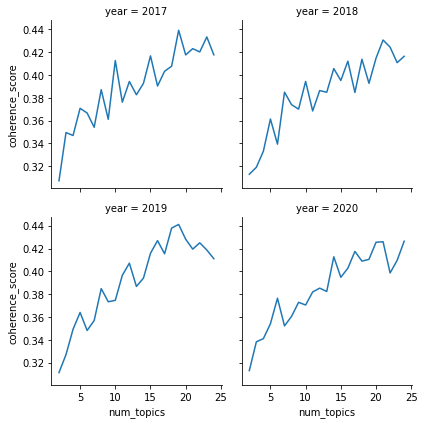

In [74]:
# Plot facetgrid
g = sns.FacetGrid(topic_posts_df, col='year', col_wrap=2)
g.map(sns.lineplot,'num_topics', 'coherence_score')

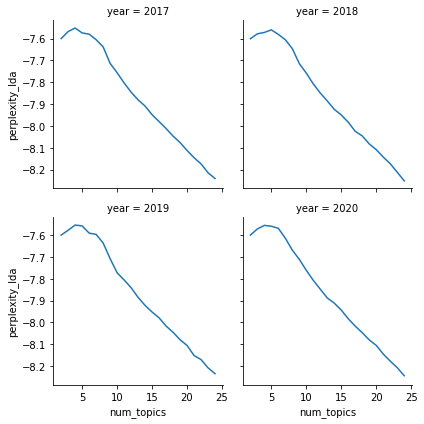

In [75]:
h = sns.FacetGrid(topic_posts_df, col='year', col_wrap=2)
h.map(sns.lineplot,'num_topics', 'perplexity_lda')

In [76]:
# Choose num_topics = 6 for each year:
print("2017 topics=6")
pprint(topic_posts_df.loc[(topic_posts_df['num_topics']==6) & (topic_posts_df['year']=='2017'), 'topics'].tolist())

# Needs to be visualised in a wordcloud

2017 topics=6
[[(0,
   '0.022*"price" + 0.020*"buy" + 0.019*"btc" + 0.013*"sell" + 0.012*"market" '
   '+ 0.012*"$" + 0.011*"time" + 0.011*"go" + 0.011*"trade" + 0.011*"coin" + '
   '0.010*"get" + 0.010*"make" + 0.010*"money" + 0.009*"good" + '
   '0.009*"invest"'),
  (1,
   '0.019*"discussion" + 0.011*"market" + 0.009*"¢s" + 0.007*"altcoins" + '
   '0.006*"“" + 0.006*"thread" + 0.006*"price" + 0.006*"relate" + 0.006*"say" '
   '+ 0.005*"ã¢â‚¬å" + 0.005*"daily" + 0.005*"\'re" + 0.005*"post" + '
   '0.005*"news" + 0.005*"year"'),
  (2,
   '0.018*"transaction" + 0.012*"use" + 0.012*"wallet" + 0.011*"satoshi" + '
   '0.011*"fee" + 0.010*"mine" + 0.009*"network" + 0.008*"make" + '
   '0.008*"address" + 0.008*"block" + 0.008*"btc" + 0.008*"miner" + '
   '0.007*"coin" + 0.007*"think" + 0.007*"people"'),
  (3,
   '0.016*"$" + 0.013*"go" + 0.011*"price" + 0.009*"get" + 0.009*"think" + '
   '0.009*"time" + 0.009*"market" + 0.008*"see" + 0.007*"long" + 0.007*"btc" + '
   '0.007*"look" + 0.007*"b

In [77]:
# Format for wordcloud
# topic_posts_df.loc[(topic_posts_df['num_topics']==6) & (topic_posts_df['year']=='2017'), 'lda_model']
topic_posts_df.iloc[4,4].show_topics(formatted=False)[0][1]

[('price', 0.021640712),
 ('buy', 0.020146772),
 ('btc', 0.019356636),
 ('sell', 0.012857346),
 ('market', 0.012267906),
 ('$', 0.01158568),
 ('time', 0.011404661),
 ('go', 0.011270883),
 ('trade', 0.011043029),
 ('coin', 0.010525827)]

In [78]:
# 1. Wordcloud of Top N words in each topic
# code adapted from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def topic_wordclouds(df, rownum, text):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

    cloud = WordCloud(stopwords=None,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=15,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

    topics = df.iloc[rownum,4].show_topics(num_words=15,formatted=False)

    fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
    fig.suptitle(f'{text}', fontsize=30)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title(f'Topic {i}', fontdict=dict(size=16))
        plt.gca().axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

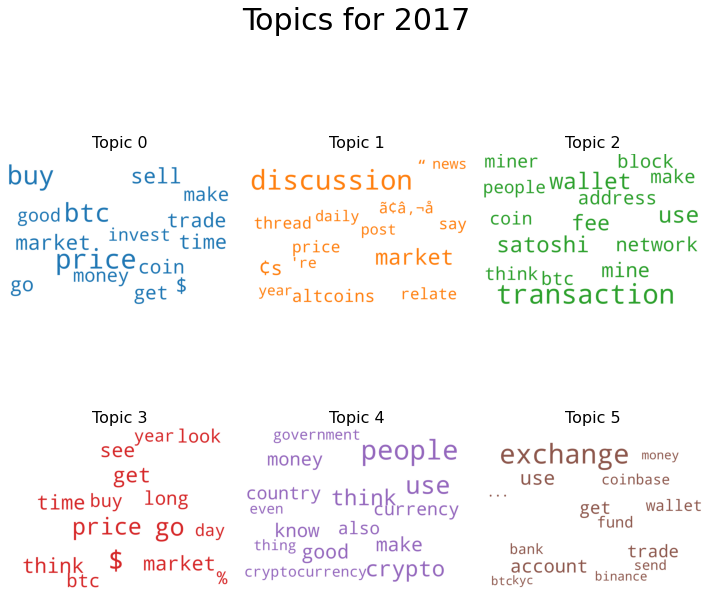

In [79]:
topic_wordclouds(topic_posts_df, 4, 'Topics for 2017')

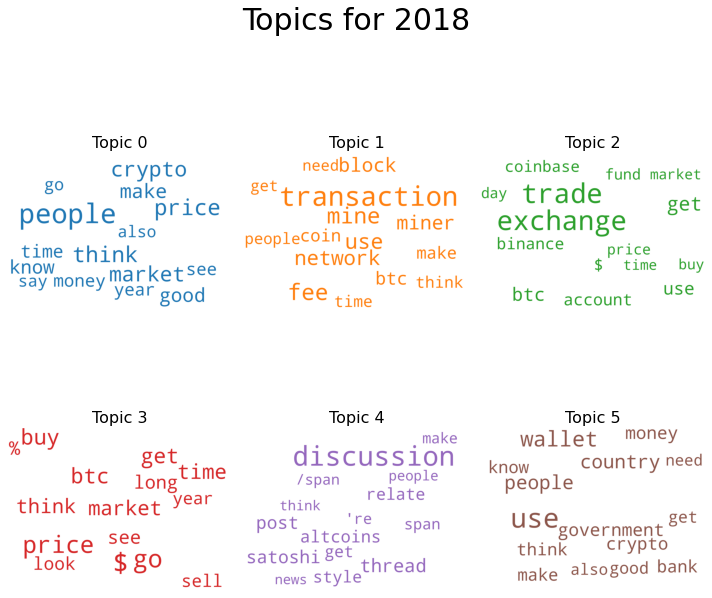

In [80]:
topic_wordclouds(topic_posts_df, 27, 'Topics for 2018')

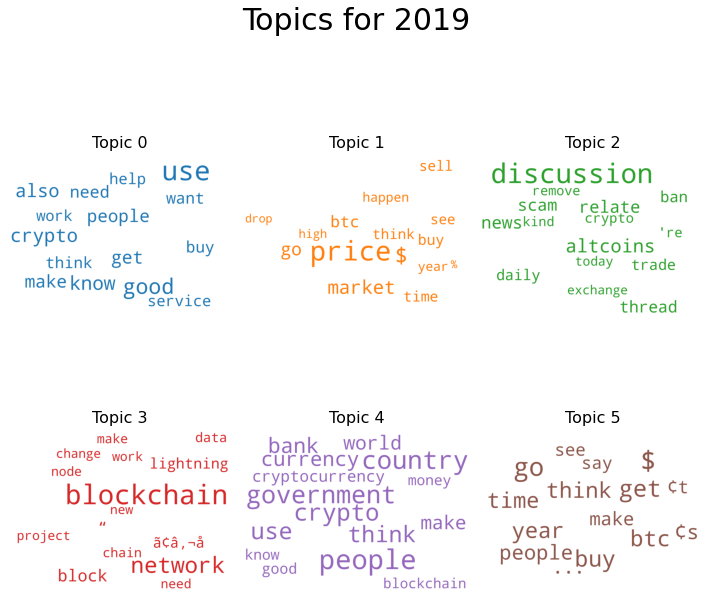

In [81]:
topic_wordclouds(topic_posts_df, 40, 'Topics for 2019')

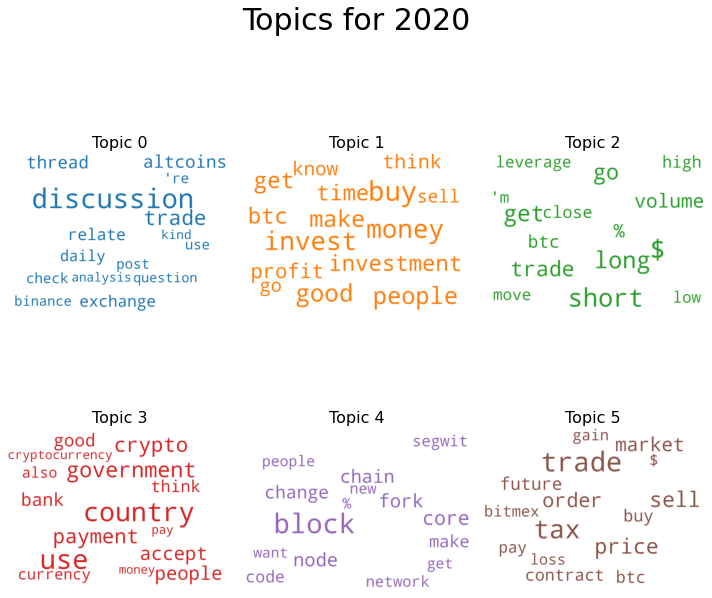

In [82]:
topic_wordclouds(topic_posts_df, 63, 'Topics for 2020')

In [35]:
with open('processed_posts_20172.pkl', 'rb') as filehandler:
    processed_posts_2017 = pickle.load(filehandler)
with open('processed_posts_20182.pkl', 'rb') as filehandler:
    processed_posts_2018 = pickle.load(filehandler)
with open('processed_posts_20192.pkl', 'rb') as filehandler:
    processed_posts_2019 = pickle.load(filehandler)
with open('processed_posts_20202.pkl', 'rb') as filehandler:
    processed_posts_2020 = pickle.load(filehandler)

In [36]:
# Function to display pyLDAvis for each year

def show_pyldavis(processed_posts, model_df):
    model = model_df.iloc[4,4]
    dictionary = corpora.Dictionary(processed_posts)
    dictionary.filter_extremes(no_below=3, no_above=0.90)
    dtm = [dictionary.doc2bow(d) for d in processed_posts]
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim.prepare(model, dtm, dictionary)

In [38]:
LDAvis_prepared_2017 = show_pyldavis(processed_posts_2017, topic_posts_2017)

In [39]:
pyLDAvis.save_html(LDAvis_prepared_2017, 'ldamodelviz_2017.html')

In [40]:
LDAvis_prepared_2018 = show_pyldavis(processed_posts_2018, topic_posts_2018)

In [41]:
pyLDAvis.save_html(LDAvis_prepared_2018, 'ldamodelviz_2018.html')

In [42]:
LDAvis_prepared_2019 = show_pyldavis(processed_posts_2019, topic_posts_2019)

In [43]:
pyLDAvis.save_html(LDAvis_prepared_2019, 'ldamodelviz_2019.html')

In [44]:
LDAvis_prepared_2020 = show_pyldavis(processed_posts_2020, topic_posts_2020)

In [45]:
pyLDAvis.save_html(LDAvis_prepared_2020, 'ldamodelviz_2020.html')